In [4]:
%matplotlib inline

import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
from pandas.tseries.resample import TimeGrouper
from pandas.tseries.offsets import DateOffset
import vincent as v


db = MongoClient('localhost',27017)['twitter_db']

# Make a query to the specific DB and Collection
collection = db['twitter_collection']



# Tweets per Language

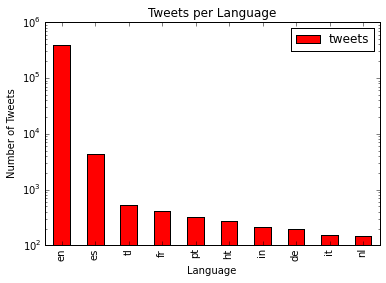

In [5]:
cursor = collection.aggregate(
    [
        {"$group": {"_id": "$lang", "count": {"$sum": 1}}},
        { "$sort": { "count": -1 }}
    ]
)
langFrame = pd.DataFrame(list(cursor))
langFrame.columns = ['lang','tweets']
langFrame = langFrame[langFrame['lang'] != 'und']
langFrame[:10].plot(x='lang',y='tweets',kind='bar',logy=True,color='red')
plt.xlabel('Language')
plt.ylabel('Number of Tweets')
plt.title('Tweets per Language')
plt.savefig('language_graph.png',dpi=180)

# Tweets over Time

In [6]:
#Select 'created_at'
cursor = collection.find({},{"created_at":1})
dateFrame = pd.DataFrame(list(cursor))

#Convert to datetime
dateFrame['created_at'] = pd.to_datetime(dateFrame['created_at'])
dateFrame.set_index('created_at', drop=False, inplace=True)
dateFrame.index = dateFrame.index.tz_localize('GMT').tz_convert('EST')
dateFrame.index = dateFrame.index - DateOffset(hours = 12)
dateFrame1m = dateFrame['created_at'].resample('1t', how='count')

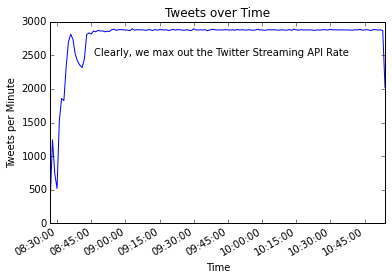

In [7]:
#Visualize
fig = plt.figure(figsize=(6,4))

plt.title("Tweets over Time")
plt.ylabel("Tweets per Minute")
fig.figsize = [6,4]
ax = dateFrame1m.plot()
ax.text("2016-02-25 09:42:00-05:00",2500,'Clearly, we max out the Twitter Streaming API Rate',horizontalalignment='center')
plt.xlabel("Time")
plt.savefig('tweets_over_time.png',dpi=180)

# Tweets Referencing Canditates

In [8]:
def get_resampled_data(candidate_name):
    candidateFrame = pd.DataFrame()
    cursor = collection.find({'text': {'$regex': candidate_name,'$options':'i'}},{"created_at":1})
    candidateFrame['created_at'] = pd.to_datetime(pd.DataFrame(list(cursor)).created_at)
    candidateFrame.set_index('created_at', drop=False, inplace=True)
    candidateFrame.index = candidateFrame.index.tz_localize('GMT').tz_convert('EST')
    candidateFrame.index = candidateFrame.index - DateOffset(hours = 12)
    per_minute = candidateFrame['created_at'].resample('1t', how='count')
    return per_minute

candidate_per_minute_data = dict()
candidates = ['Trump','Rubio','Kasich','Carson','Cruz']
for name in candidates:
    candidate_per_minute_data[name] = get_resampled_data(name.lower())
    print "Finished " + name

Finished trump
Finished rubio
Finished kasich
Finished carson
Finished cruz


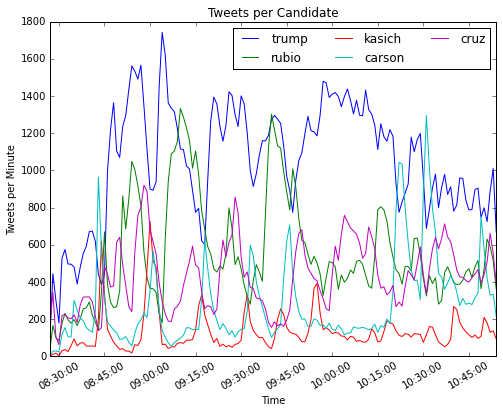

In [9]:

fig = plt.figure(figsize=(8,6))
plt.xticks(rotation=30)

#Visualize
plt.title("Tweets per Candidate")
plt.ylabel("Tweets per Minute")
for name in candidates:
    plt.plot(candidate_per_minute_data[name].index.to_pydatetime(),candidate_per_minute_data[name])
plt.rcParams["figure.figsize"] = [15,9]

plt.legend(candidates, loc='upper right',ncol=3)
plt.xlabel("Time")
plt.savefig('tweets_per_candidate.png',dpi=180)

# Carson Analytics

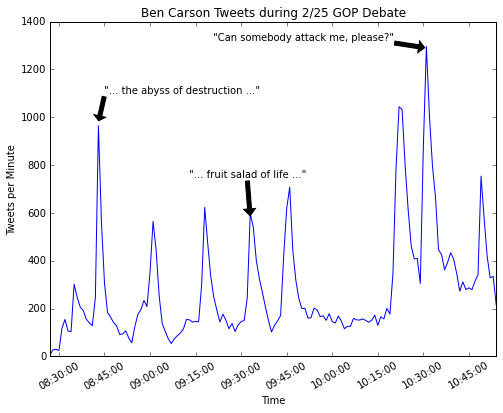

In [10]:
#Visualize
fig = plt.figure(figsize=(8,6))

plt.title("Ben Carson Tweets during 2/25 GOP Debate")
plt.ylabel("Tweets per Minute")
plt.plot(candidate_per_minute_data['carson'].index.to_pydatetime(),candidate_per_minute_data['carson'])
plt.xticks(rotation=30)

plt.xlabel("Time")
#plt.text("2016-02-25 10:20:00-05:00",1320, '"Can somebody attack me, please?"', horizontalalignment='center')
plt.annotate('"... fruit salad of life ..."',xy=("2016-02-25 9:33:00-05:00",580),
             xytext=("2016-02-25 9:32:00-05:00",750),horizontalalignment='center',
             arrowprops=dict(facecolor='black', shrink=0.05, frac=.2))
plt.annotate('"Can somebody attack me, please?"',xy=("2016-02-25 10:31:00-05:00",1290),
             xytext=("2016-02-25 10:20:00-05:00",1320),horizontalalignment='right',
             arrowprops=dict(facecolor='black', shrink=0.05, frac=.2))
plt.annotate('"... the abyss of destruction ..."',xy=("2016-02-25 8:43:00-05:00",980),
             xytext=("2016-02-25 8:45:00-05:00",1100),horizontalalignment='left',
             arrowprops=dict(facecolor='black', shrink=0.05, frac=.2))
plt.savefig('carson_tweets.png',dpi=180)

# Stack Graph of Candidate Tweets

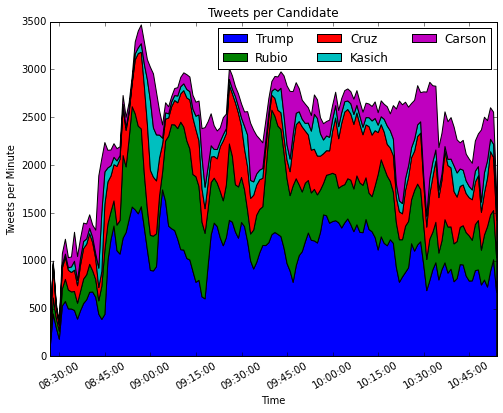

In [46]:
fig = plt.figure(figsize=(8,6))

plt.title("Tweets per Candidate")
plt.ylabel("Tweets per Minute")
plt.xlabel("Time")
fullDataFrame = pd.DataFrame()
plt.xticks(rotation=30)

for name in candidates:
    fullDataFrame[name] = candidate_per_minute_data[name]
polys = plt.stackplot(fullDataFrame.index,fullDataFrame.trump,fullDataFrame.rubio,fullDataFrame.cruz,
              fullDataFrame.kasich,fullDataFrame.carson)
legendProxies = []
for poly in polys:
    legendProxies.append(plt.Rectangle((0, 0), 1, 1, fc=poly.get_facecolor()[0]))
    
plt.legend(legendProxies, ['Trump','Rubio','Cruz','Kasich','Carson'],ncol=3)

plt.savefig('stacked_tweets_over_time.png',dpi=180)

# Tweet Totals

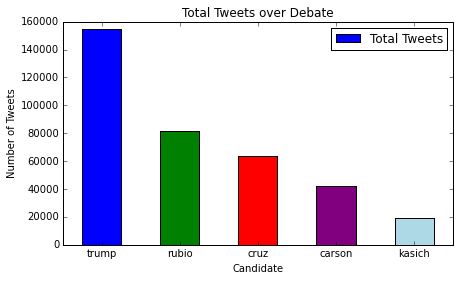

In [72]:

totalsFrame = pd.DataFrame()
totalsFrame['names'] = candidates
totalsFrame['Total Tweets'] = [candidate_per_minute_data[name].sum() for name in candidates]
totalsFrame = totalsFrame.sort_values(by='Total Tweets',ascending=False)

totalsFrame.plot(x='names',kind='bar',color=['b','g','r','purple','lightblue'],figsize=(7,4))
plt.xlabel('Candidate')
plt.ylabel('Number of Tweets')
plt.title('Total Tweets over Debate')
plt.xticks(rotation=0)
plt.savefig('total_tweets.png',dpi=300)


# Coordinate Data

I tried to get Matplotlib's Basemap library to work, but I couldn't get it to cooperate with Jupyter. Given that of the ~400k tweets I only got ~400 points, it seemed rather pointless to graph them

In [2]:
coordinates_df = pd.DataFrame(list(collection.find({'coordinates':{'$exists':True,'$ne': None}})))
lats,longs = list(),list()
for _dict in coordinates_df['coordinates']:
    if 'coordinates' in _dict:
        lats.append(_dict['coordinates'][0])
        longs.append(_dict['coordinates'][1])
avg_lat = pd.DataFrame(lats).median()[0]
avg_lon = pd.DataFrame(longs).median()[0]

NameError: name 'pd' is not defined